In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import pandas as pd
import math
import numpy as np
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [3]:
features = pd.read_csv(open('/gdrive/My Drive/DengueDA/DATA/dengue_features_train.csv', 'r'))
cases = pd.read_csv(open('/gdrive/My Drive/DengueDA/DATA/dengue_labels_train.csv', 'r'))

# merge features and the target variable "total_cases"
data = features
data['total_cases']= cases['total_cases']

data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [8]:
# seperate the two cities sj and iq data.

sj_data = data.loc[data['city'] == 'sj']
iq_data = data.loc[data['city'] == 'iq']

#set datetime indexes
sj_data = sj_data.set_index(pd.date_range(sj_data['week_start_date'][0], periods=sj_data.shape[0], freq="W-MON"))
iq_data = iq_data.set_index(pd.date_range('2000-06-26', periods=iq_data.shape[0], freq="W-MON"))

sj_data=sj_data.drop(['city'], axis = 1)
iq_data=iq_data.drop(['city'], axis = 1)
sj_data=sj_data.drop(['week_start_date'], axis = 1)
iq_data=iq_data.drop(['week_start_date'], axis = 1)

In [29]:
sj_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [78]:
 def remove_null(x):
    t_f=pd.isnull(x)
    for i in t_f:
        c=0
        if(i=='city' or i=='week_start_date'):
            continue 
        mean_value=x[i].mean()
        x[i].fillna(value=mean_value, inplace=True)

# replace null values with averages
remove_null(iq_data)
remove_null(sj_data)

Time series Decomposition:

<Figure size 432x288 with 0 Axes>

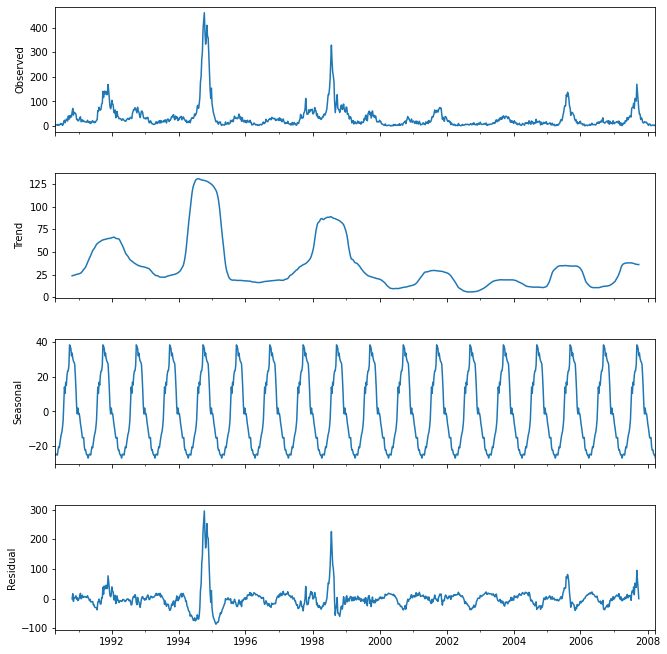

In [14]:
# for san juan city
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sj_data['total_cases'], model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 10)

<Figure size 432x288 with 0 Axes>

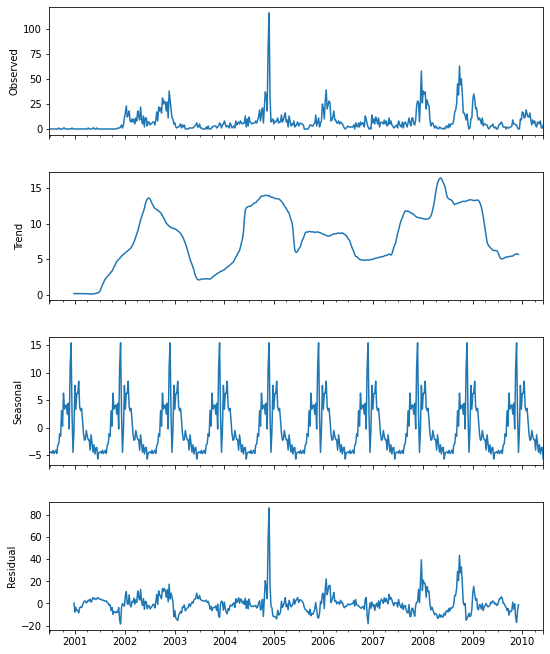

In [15]:
# for equitos city
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(iq_data['total_cases'], model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 10)

Here we can observe seasonality of annual frequency in both the cities.

In [79]:
# train and test split of 80:20
iq_train = iq_data[:int((iq_data.shape[0])*0.8)]
iq_test = iq_data[int((iq_data.shape[0])*0.8):]

y_train = iq_train['total_cases']
y_test = iq_test['total_cases']

iq_train = iq_train.drop(['total_cases'], axis = 1)
iq_train = iq_train.drop(['year'], axis = 1)
iq_train = iq_train.drop(['weekofyear'], axis = 1)

iq_test = iq_test.drop(['total_cases'], axis = 1)
iq_test = iq_test.drop(['year'], axis = 1)
iq_test = iq_test.drop(['weekofyear'], axis = 1)
#From here on we'll be focusing only the Iquitos data, in order to simplify our model application and analysis.

Principal Component Analysis:

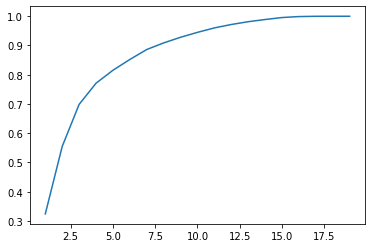

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler() 
IQ_train = sc.fit_transform(iq_train)
IQ_test = sc.transform(iq_test)
#X_train.shape
elbow=[]
ii=[]
for i in range(1,20):
    pca = PCA(n_components = i)
    iq_trai =pca.fit_transform(IQ_train)
    iq_tes = pca.transform(IQ_test)
    explained_variance = pca.explained_variance_ratio_
    elbow.append(sum(explained_variance))
    ii.append(i)

plt.plot(ii,elbow)

analysing the above elbow graph, we determined the elbow point to be 5, hence we reduce the number of dimentions to 5 using PCA.

In [57]:
pca = PCA(n_components = 5)
IQ_train =pca.fit_transform(IQ_train)
IQ_test = pca.transform(IQ_test)
explained_variance = pca.explained_variance_ratio_
IQ_train.shape

(416, 5)

Linear Regression Model:

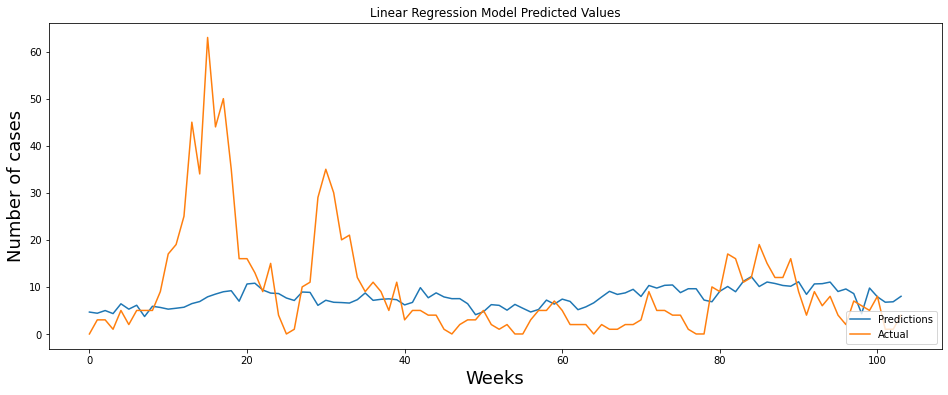

MSE for real vs predicted values: 132.2132623019259


In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
LR_model = LinearRegression()
LR_preds=pd.DataFrame()
# print(len(list(X_test)),len(list(y_train.to_numpy())))
# print(X_train.shape)
LR_model.fit(IQ_train, y_train)
LR_preds['cases'] = LR_model.predict(IQ_test)
LR_MSE = mean_squared_error(y_test,LR_preds['cases'])

# Plot the data
plt.figure(figsize=(16,6))
plt.title('Linear Regression Model Predicted Values')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.plot(LR_preds['cases'])
plt.plot(list(y_test))
plt.legend(['Predictions','Actual'], loc='lower right')
plt.show()

print('MSE for real vs predicted values:', LR_MSE)

Support Vector Regression Model:

MSE for real vs predicted values: 153.11102633005248


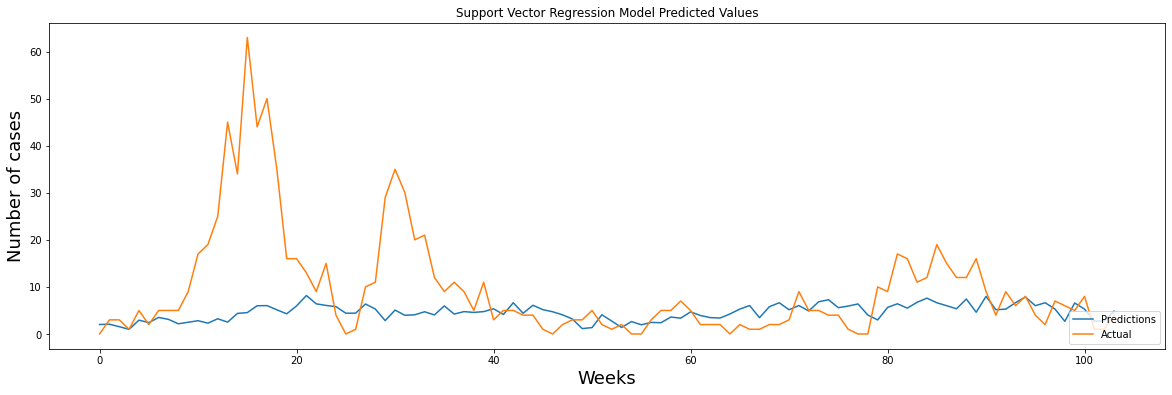

In [62]:
from sklearn import svm

clf = svm.SVR()
clf.fit(IQ_train, y_train)

pred_svr=clf.predict(IQ_test)
SVR_MSE = mean_squared_error(y_test,pred_svr)
plt.figure(figsize=(20,6))
plt.title('Support Vector Regression Model Predicted Values')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.plot(pred_svr)
plt.plot(list(y_test))
plt.legend(['Predictions','Actual'], loc='lower right')

print('MSE for real vs predicted values:', SVR_MSE)

SARIMA Model

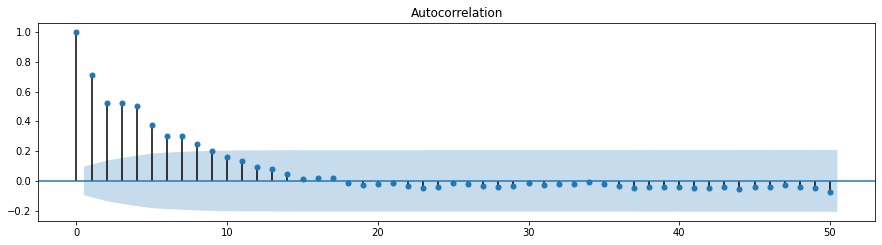

In [60]:
# Plot ACF Graph for the output variable 'number of cases per week'
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(y_train,lags=50,ax=ax1)

here we see gradual decrease of the ACF plot indicating that the data is not stationary.  Hence we diffrentiate to make it stationary.

In [67]:
y_train_diff = (y_train.diff(1)).dropna()

def adfuller_test(stock):
    result=adfuller(stock)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating it is non-stationary ")

adfuller_test(y_train_diff)

ADF Test Statistic : -10.814739705636564
p-value : 1.8696353172581764e-19
#Lags Used : 5
Number of Observations Used : 409
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


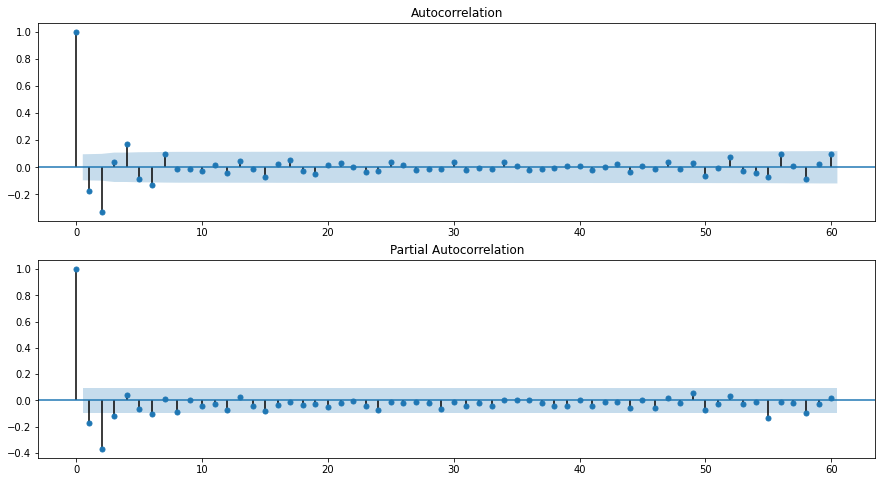

In [68]:
# plot the pacf and acf plots to find the optimal value of the SARIMA parameters p,d,q and s.

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(y_train_diff.dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y_train_diff.dropna(),lags=60,ax=ax2)

From the ACF plot, we can determine the value of q=1 as the value rapidly decreases and goes below zero at 1.
Similarly from the PACF plot, we can determine the value of p=1 as the value rapidly decreases and goes below zero at 1.


The value for the diffrence d will be 1 as we differenced the data by a lag of 1 to make the data stationary.

In [69]:
# SARIMAX takes in values of (p,d,q,s) - where s is seasonality 
# The value for seasonality will be 52 as the frequency of seasonality is yearly (52 weeks in a year)
SARIMAX_model=sm.tsa.statespace.SARIMAX(endog=y_train,order=(1, 1, 1),seasonal_order=(1,1,1,52))

SARIMAX_model_fit=SARIMAX_model.fit(disp=False)


MSE for real vs predicted values: 129.64786728048765


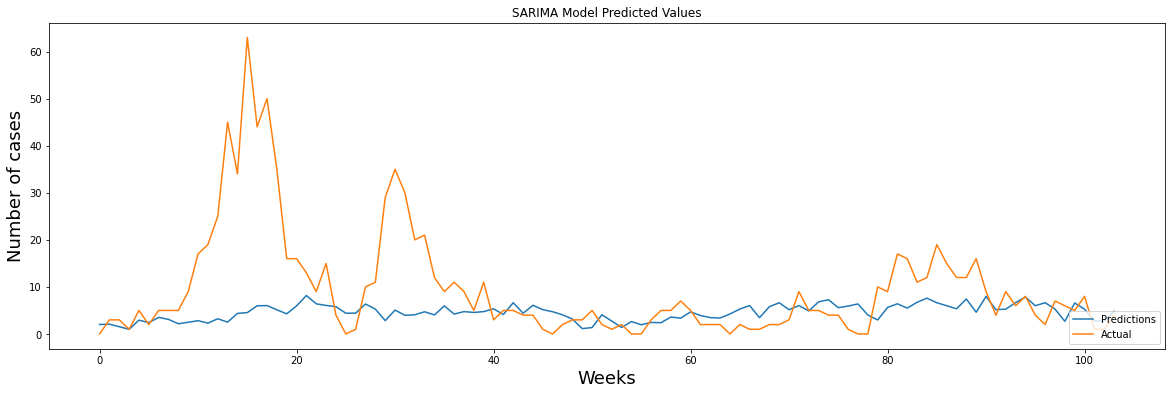

In [71]:
predicted_values_SARIMA = SARIMAX_model_fit.predict(start =416, end =519, dynamic= True )

SARIMA_MSE = mean_squared_error(predicted_values_SARIMA,y_test)

plt.figure(figsize=(20,6))
plt.title('SARIMA Model Predicted Values')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.plot(pred_svr)
plt.plot(list(y_test))
plt.legend(['Predictions','Actual'], loc='lower right')

print('MSE for real vs predicted values:', SARIMA_MSE)

SARIMAX MODEL:

In [92]:
SARIMAX_model=sm.tsa.statespace.SARIMAX(endog=y_train,order=(1, 1, 1),seasonal_order=(1,1,1,52), exog=IQ_train)
SARIMAX_model_fit=SARIMAX_model.fit(disp=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MSE for real vs predicted values: 131.63347067628837


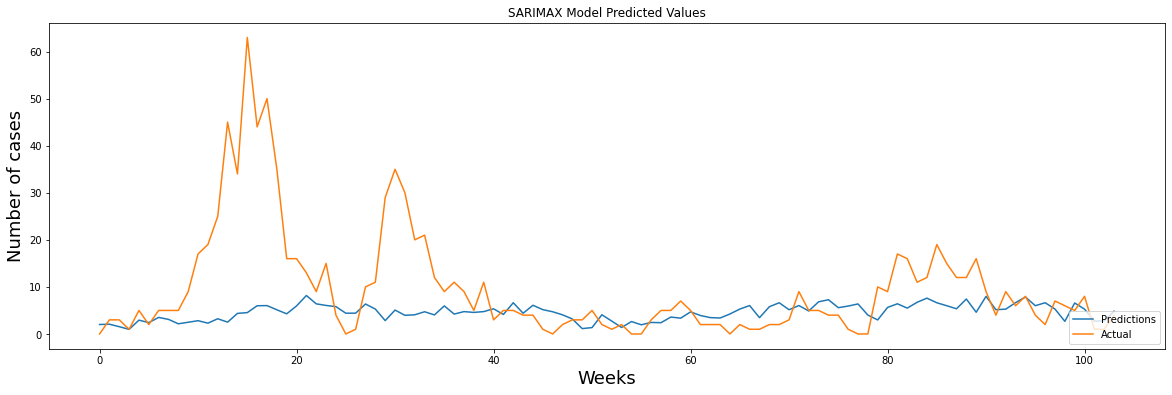

In [93]:
predicted_values_SARIMAX = SARIMAX_model_fit.predict(start =416, end =519, dynamic= True,exog=IQ_test)
SARIMAX_MSE = mean_squared_error(predicted_values_SARIMAX,y_test)

plt.figure(figsize=(20,6))
plt.title('SARIMAX Model Predicted Values')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.plot(pred_svr)
plt.plot(list(y_test))
plt.legend(['Predictions','Actual'], loc='lower right')

print('MSE for real vs predicted values:', SARIMAX_MSE)

MSE for real vs predicted values When exog is PCA reduced variables : 127.80934217882411